In [6]:
!sudo apt-get update -y
!sudo apt install libgl1-mesa-glx -y

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic InRelease [242 kB]
Get:3 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1392 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]      
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]    
Get:6 http://archive.ubuntu.com/ubuntu bionic/restricted amd64 Packages [13.5 kB]
Get:7 http://archive.ubuntu.com/ubuntu bionic/multiverse amd64 Packages [186 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic/universe amd64 Packages [11.3 MB]
Get:9 http://security.ubuntu.com/ubuntu bionic-security/multiverse amd64 Packages [43.5 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [304 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [1963 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic/main amd64 Packages [1344 kB]   
Get:13 http://a

7Progress: [ 15%] [########..................................................] 87Progress: [ 15%] [########..................................................] 8Selecting previously unselected package libdrm-nouveau2:amd64.
Preparing to unpack .../07-libdrm-nouveau2_2.4.101-2~18.04.1_amd64.deb ...
7Progress: [ 16%] [#########.................................................] 8Unpacking libdrm-nouveau2:amd64 (2.4.101-2~18.04.1) ...
7Progress: [ 18%] [##########................................................] 8Selecting previously unselected package libdrm-radeon1:amd64.
Preparing to unpack .../08-libdrm-radeon1_2.4.101-2~18.04.1_amd64.deb ...
7Progress: [ 18%] [##########................................................] 8Unpacking libdrm-radeon1:amd64 (2.4.101-2~18.04.1) ...
7Progress: [ 19%] [###########...............................................] 8Selecting previously unselected package libglapi-mesa:amd64.
Preparing to unpack .../09-libglapi-mesa_20.0.8-0ubuntu1~18.04

7Progress: [ 60%] [##################################........................] 8dpkg: warning: failed to open configuration file '/home/10731leon/.dpkg.cfg' for reading: Permission denied
Setting up libxcb-present0:amd64 (1.13-2~ubuntu18.04) ...
7Progress: [ 60%] [##################################........................] 87Progress: [ 61%] [###################################.......................] 8Setting up libglvnd0:amd64 (1.0.0-2ubuntu2.3) ...
7Progress: [ 63%] [####################################......................] 8Setting up libxcb-dri2-0:amd64 (1.13-2~ubuntu18.04) ...
7Progress: [ 63%] [####################################......................] 8Setting up libxcb-dri3-0:amd64 (1.13-2~ubuntu18.04) ...
7Progress: [ 65%] [#####################################.....................] 87Progress: [ 65%] [#####################################.....................] 8Setting up libxcb-glx0:amd64 (1.13-2~ubuntu18.04) ...
7Progress: [ 66%] [########################

In [7]:
import os
import tensorflow as tf

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import (
    Dense, Conv2DTranspose, Conv2D, BatchNormalization,
    LeakyReLU, Dropout, Reshape, Flatten
)

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
''' basic package '''
import os
import time
import glob
from IPython.display import display, Image, clear_output

import numpy as np

import tensorflow as tf

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import (
    Dense, Conv2DTranspose, Conv2D, BatchNormalization,
    LeakyReLU, Dropout, Reshape, Flatten
)

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import cv2
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
def load(image_file):
    image = tf.io.read_file(image_file)
    # 將 image decode 為 unit8 的 tensor
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]

    # 因為原始圖片是將 image 與 label 黏在一起，所以這邊要把他們切開
    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]

    # 將 image datatype 改為 float32
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image
def resize(input_image, real_image, height, width):
    # 將圖片放大成我們想要的大小，方法是用 NEAREST_NEIGHBOR 最鄰近插值法
    input_image = tf.image.resize(input_image, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image


def random_crop(input_image, real_image):
    # 將圖片一張一張疊起來(類似append)
    stacked_image = tf.stack([input_image, real_image], axis=0)
    # 將圖片隨機切割成我們想要的大小： 256 x 256
    # 我們不想要隨機切 stack_size 與 channel 的部分，故就輸入其原始的 shape: stack_size=2 和 channel=3
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]


# 將圖片正規化到 -1 到 1 之間
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image
@tf.function()
# data augmentation
def random_jitter(input_image, real_image):
    # 調整圖片大小至 286 x 286 x 3
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # 隨機切割圖片至 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)

    # 隨機水平翻轉圖片
    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image
# 定義 train/test generator
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image


# no jitter at testing!
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                     IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image
def dataSET(traindir,testdir):
    train_dataset = tf.data.Dataset.list_files(r'{}/*.jpg'.format(traindir))
    # num_parallel_calls 是一次準備多少圖片一起處理，他可以最佳化到底要讀多少圖的這個參數
    train_dataset = train_dataset.map(load_image_train,
                                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_dataset = train_dataset.shuffle(BUFFER_SIZE)
    train_dataset = train_dataset.batch(BATCH_SIZE)


    test_dataset = tf.data.Dataset.list_files(r'{}/*.jpg'.format(testdir))
    test_dataset = test_dataset.map(load_image_test)
    test_dataset = test_dataset.batch(BATCH_SIZE)
    return train_dataset,test_dataset
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)  # mean=0, stddev=0.02

    result = tf.keras.Sequential()

    # 因為預設會使用 batchnorm，所以不需要加 bias
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()

    # 還記得 Vanilla GAN 裡提到的 Conv2DTranspose 的介紹嗎？忘記了可以再回去看喔！
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result
def Generator():
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    # 最後 output 的 range 要在 -1 ~ 1 之間，所以選用的 activation function 是 "tanh"
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')  # (bs, 256, 256, 3)

    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None, None, 3])
    x = inputs

    # Downsampling
    # 用一個 list 將每層的輸出存起來，之後再 Upsampling 時可以使用
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])  # 把 skip connections 的值存起來並顛倒，後面在 upsampling 時會用到

    # Upsampling 和 skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar], axis=-1)  # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss


def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # 加入 L1 loss 來增加模型的 robustness 與細緻度， 影像也較 L2 loss 不模糊
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss

LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss


def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # 加入 L1 loss 來增加模型的 robustness 與細緻度， 影像也較 L2 loss 不模糊
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss
def generate_images(model, test_input, tar):

    prediction = model(test_input, training=True)  # 這邊設 training=True 是希望能得到 test_input 的一些統計量
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # 將圖片像素值調整至 0 - 1 之間才能 plot
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()


@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                 discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))


def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()

        # Train
        for input_image, target in train_ds:
            train_step(input_image, target)

        # 每 10 個 epochs 顯示一次圖片
        if (epoch + 1) % 10 == 0:
            for example_input, example_target in test_ds.take(1):
                generate_images(generator, example_input, example_target)

        # 每 50 個 epochs 存一次 weight
        if (epoch + 1) % 50 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)



In [8]:
OUTPUT_CHANNELS = 3
generator = Generator()
discriminator = Discriminator()
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [9]:

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

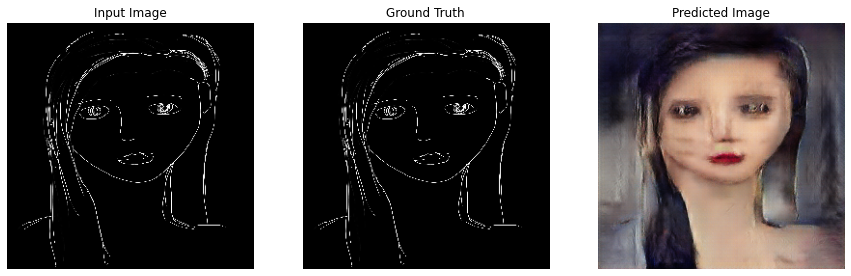

In [10]:
image = tf.io.read_file(r'/home/10731leon/gan-alg/pix2pix-fanbing/fand.jpg')
image = tf.image.decode_jpeg(image,channels=3)
    # 將 image decode 為 unit8 的 tensor
image=tf.cast(image, tf.float32)
image = tf.image.resize(image, [256, 256],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
image = (image / 127.5) - 1
generate_images(generator, image[tf.newaxis, ...] , image[tf.newaxis, ...] )